In [1]:
import pandas as pd

from tqdm import tqdm

from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score, train_test_split

from news_vec.utils import read_json_gz_lines

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

%matplotlib inline

In [4]:
accs = pd.DataFrame(list(tqdm(read_json_gz_lines('../data/clf-imp-acc-ts.json/'))))

136500it [00:00, 334957.94it/s]


In [7]:
accs

,acc,domain,window
0,0.454545,cnn.com,13
1,0.363636,bloomberg.com,71
2,0.333333,buzzfeed.com,58
3,0.515151,buzzfeed.com,53
4,0.484848,bloomberg.com,35
5,0.515151,npr.org,27
6,0.606061,npr.org,13
7,0.333333,nytimes.com,67
8,0.454545,bloomberg.com,5
9,0.424242,washingtonpost.com,37


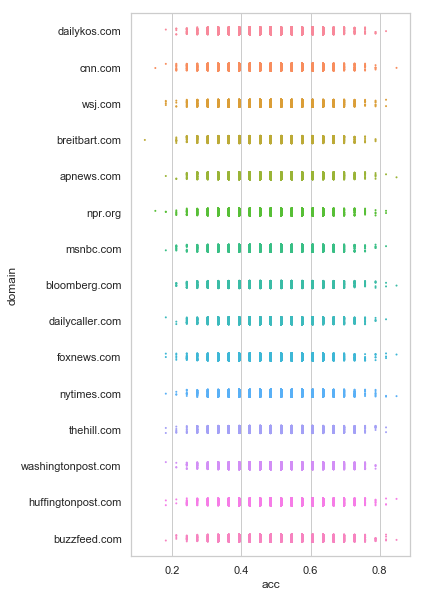

In [6]:
order = accs.groupby('domain').mean().sort_values('acc').index
plt.figure(figsize=(5,10))
sns.stripplot(x='acc', y='domain', data=accs, s=2, order=order)

In [5]:
articles = pd.DataFrame(list(tqdm(read_json_gz_lines('../../data/clf-articles.json/'))))

1081790it [00:16, 65220.78it/s]


In [6]:
min_count = articles.groupby('domain').size().min()

In [7]:
def imp_preds(domain):
    
    pdf = articles[articles.domain==domain].sample(min_count).copy()
    pdf['imp_rank'] = pdf.impressions.rank(pct=True)
    pdf['imp_high'] = pdf.imp_rank > 0.5
    
    rows_train, rows_test = train_test_split(pdf)
    
    X_train, y_train = rows_train.clf_tokens, rows_train.imp_high
    X_test, y_test = rows_test.clf_tokens, rows_test.imp_high
    
    tv = TfidfVectorizer(
        analyzer='word',
        tokenizer=lambda x: x,
        preprocessor=lambda x: x,
        ngram_range=(1,3),
        token_pattern=None,
    )
    
    X_train = tv.fit_transform(X_train)
    X_test = tv.transform(X_test)
    
    clf = LogisticRegression(solver='lbfgs')
    fit = clf.fit(X_train, y_train)
    
    ti = fit.classes_.tolist().index(True)
    
    preds = fit.predict_proba(X_test)
    
    rows_test = rows_test.copy()
    rows_test['p_high'] = preds[:,1]
    
    return rows_test

In [8]:
def plot_preds(domain):
    
    pdf = imp_preds(domain)
    
    for r in pdf.sort_values('p_high', ascending=False).head(20).itertuples():
        print(r.p_high, ' '.join(r.clf_tokens))
        
    print('\n')
    for r in pdf.sort_values('p_high', ascending=True).head(20).itertuples():
        print(r.p_high, ' '.join(r.clf_tokens))
    
    sns.jointplot(y='p_high', x='imp_rank', data=pdf, s=1)
    plt.show()

0.8781100548159559 stephen colbert actually just congratulated trump for something
0.8720559638109205 democrats are raising money hand over fist with trump in the white house
0.8647344660048331 white house reviewing democratic coalition report on trump s russian ties that fbi ignored
0.8556114587929945 white house admits trump s tapes tweet aimed to impugn comey
0.8543300527614074 ex fox news exec bill shine joins trump white house
0.8536947534849673 omarosa says trump is truly a racist concedes complicity in white house deceit
0.8521771202095836 white house petition calling for release of trump s tax returns gets over # signatures
0.8503010606485664 donald trump jr knew he was meeting with kremlin linked lawyer
0.8498162927574813 jeff sessions says he s never been briefed on russian meddling
0.8497661733184455 jimmy kimmel tries to trick trump supporters into signing up for obamacare
0.8467596414394136 trump says he stands with hurricane victims he s ignored for months
0.8415953923262

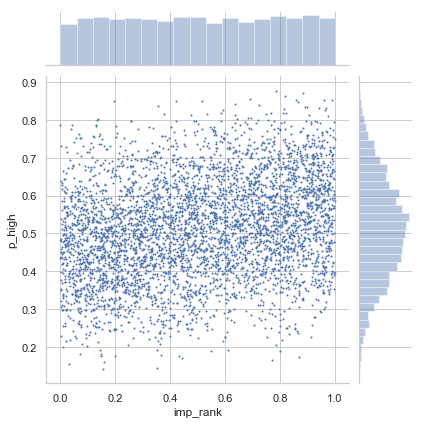

In [9]:
plot_preds('huffingtonpost.com')

0.8598402837833303 trump considered mueller for fbi director before he was named special counsel
0.8475611397817997 graham says trump called after senate speech about mccain
0.8299938747440181 trump accuses obama of wiretapping trump tower
0.8149372514947115 trump telling people nunes memo will discredit mueller probe
0.8108525416212814 trump approval rating hits new low hours before inauguration
0.8089730407846315 ivanka trump chelsea clinton defend malia obama amid tabloid coverage
0.8068752409717143 white house releases trump pence official portraits
0.8051694220158789 trump white house senior staff have private email accounts
0.7999492914771843 of course memo does not vindicate trump in russia probe
0.7965577392204927 ivanka trump the best liked white house staffer
0.7953974551151024 justice department watchdog says comey deviated from fbi procedures in clinton email probe
0.7933673765367818 trump says he did nothing wrong after cohen tape revelation
0.7869984811536119 maxine water

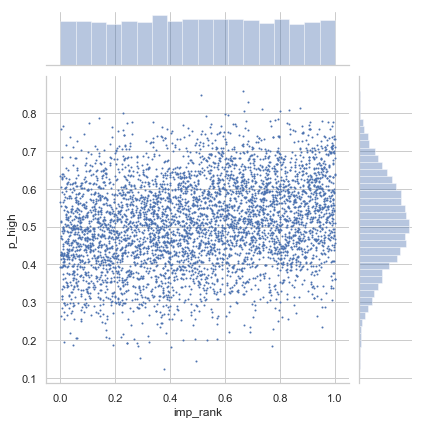

In [10]:
plot_preds('thehill.com')

0.9297059842780833 trump channels old hickory
0.896399808077623 did the president order mueller to be fired fake news trump says
0.886761711342488 he s a gop immigration hard liner so why is he trailing in trump country
0.8673546639493761 republicans worry that white house disarray is undermining trump
0.8673198553883203 trump says he s sending the national guard on the border many are nt sure why
0.8642178891126532 to allies chagrin trump swerves left
0.8632840800616631 trump so far is more farce than tragedy
0.8624417236973472 shopping becomes a political act in the trump era
0.8582452580238564 trump wants to aid only america s friends if only it were that easy
0.8535207261716578 trump sticks a fork in comey
0.8512281602140069 trump is wrong to skip the white house correspondents dinner
0.8500700113587488 enough trump bashing democrats
0.843981209619328 deep in trump country a big stake in health care
0.8388561631204897 the nicknames of trump s adversaries
0.8388403874878363 times re

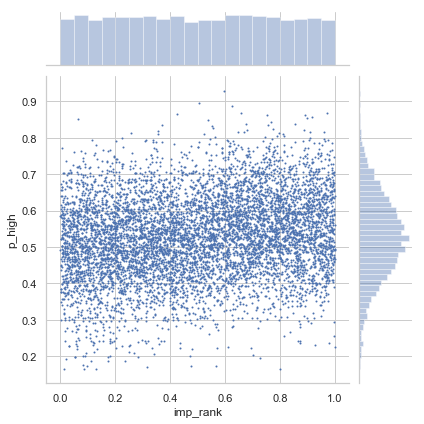

In [11]:
plot_preds('nytimes.com')

0.8796354617508313 black pro trump conservative begins pro trump empire
0.8744768397292842 boris johnson praised trump on trump s favourite tv show
0.8655086240311273 trump s tweets are still snagging the justice department s travel ban defense
0.8625027723355327 trump uses facebook exec tweet to call media fake news
0.8621603165845897 the justice department just argued against gay rights in a major federal case
0.8574485641595395 a former russian spy worked on a trump moscow deal while trump was running for president
0.8499112451890646 trump s press conference was a rallying cry for the pro trump media
0.8444567826874473 trump attacked the media for running fake news during a combative press conference
0.8422077021594598 how russians tried to infiltrate the trump campaign
0.8411889798094525 trump s lawyer the says who guy is now being investigated in the russia probe
0.8382848989032302 a foreign policy expert says calling out trump s hate speech hurt her career
0.835344536751035 the j

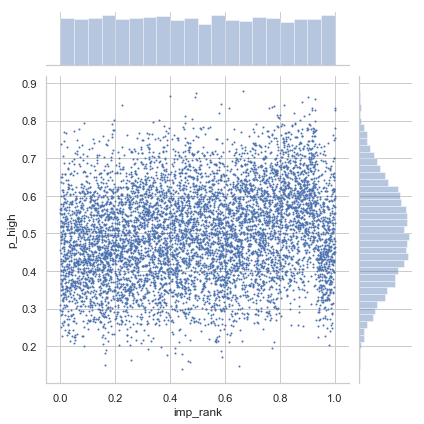

In [12]:
plot_preds('buzzfeed.com')

0.971881743064384 the blundering trump is
0.8890922266561073 trump s christmas sweater
0.8702740443856248 trump is kowtowing to the kremlin again why
0.8639790730464353 congress must vote on trump s war trump himself said so in #
0.8618801108834905 a bored trump beefs with bloomberg news
0.8591514961744238 the unpopular trump is shrinking the gop
0.8581640622818676 north korea taps gop analysts to better understand trump and his messages
0.8568222961152799 trump has americans frightened about north korea
0.8552654891532947 trump has spent # percent of his presidency at trump owned or
0.8544295727432769 trump would cut more in federal infrastructure spending than he proposes to add democrats say
0.8541863968663334 white house stabilizers gone trump calling his own shots
0.853725506577846 why some inside the white house see trump s media feud as winning
0.8517131804478763 president trump has made more than # false or misleading claims
0.8503708070927103 trump s latest empty threat on nor

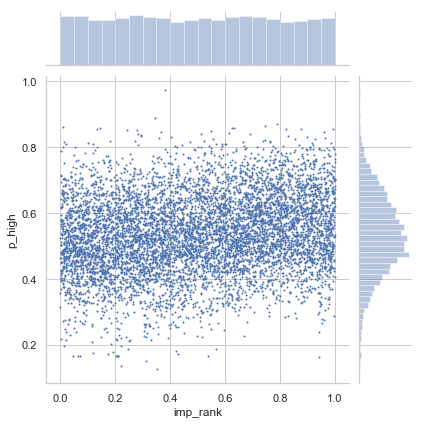

In [13]:
plot_preds('washingtonpost.com')